**Name: Trilokinath Modi**

Disclaimer: The entire code is heavily influenced by the sample code provided in the course. Modifications in classes were made to perform certain tasks, but the structure of the code is largely maintained inpar with the sample code.

# Basic Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import the PyTorch library
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# a couple of utilities from the scikit-learn library
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# for time measurements
import time

# some utilities for counting
from collections import defaultdict, Counter

# plotting
import matplotlib.pyplot as plt
import numpy as np
from spacy.lang.en import English

# plotting cosmetics
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

nlp = English()

In [5]:
filePath = "/content/drive/My Drive/MLNLP/Assignment3/a3_data/wsd_train.txt"
filePathTest = "/content/drive/My Drive/MLNLP/Assignment3/a3_data/wsd_test_blind.txt"
filePathResult = "/content/drive/My Drive/MLNLP/Assignment3/"
fileEvaluatePy = "/content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py"
fileEvaluateTest = "/content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt"

In [6]:
# !unzip 'drive/My Drive/MLNLP/Assignment3/a3_test.zip' -d 'drive/My Drive/MLNLP/Assignment3/'

In [7]:
def readData(fileName):
    X = []
    Y = []
    posVector = []
    fileHandler = open(fileName, encoding='utf-8')
    with fileHandler:
        for line in fileHandler:
            sense, lemma, position, doc = line.strip().split(maxsplit=3)
            X.append(doc)
            Y.append(sense)
            posVector.append(position)
    return X, Y, posVector

def writeData(fileName, resultList):
  fileHandler = open(fileName, 'w')
  with fileHandler:
    for iResult in resultList:
        fileHandler.write("%s\n" % iResult)

def evaluateFile(resultFile):
  !python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt resultFile

# Setup classes used by all methods

The vocabulary class is modified to add 2 special cases used in continuous bag of words approach. The special cases are discussed under the CBOW title. Specifically, the build method is modified.

In [8]:
PAD = '___PAD___'
UNKNOWN = '___UNKNOWN___'

class Vocabulary:
    """Manages the numerical encoding of the vocabulary."""
    
    def __init__(self, tokenizer=None, max_voc_size=None):

        # String-to-integer mapping
        self.stoi = None

        # Integer-to-string mapping
        self.itos = None

        # Tokenizer that will be used to split document strings into words.
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = lambda s: s.split()

        # Maximally allowed vocabulary size.
        self.max_voc_size = max_voc_size
        
    def build(self, docs, position = None, ngrams = None, flagNoStop = None):
        """Builds the vocabulary, based on a set of documents."""
        
        if ngrams == None:
          # Sort all words by frequency
          word_freqs = Counter(w for doc in docs for w in self.tokenizer(doc))
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)
        
        elif flagNoStop == None:
          # Sort all words by frequency
          positionIndex = 0
          word_freqs = Counter()
          for doc in docs:
            currentDoc = self.tokenizer(doc)
            if int(position[positionIndex]) + ngrams < len(currentDoc) and int(position[positionIndex]) - ngrams >= 0:
              for words in range(int(position[positionIndex]) - ngrams, int(position[positionIndex]) + ngrams + 1):        
                word_freqs.update([currentDoc[words]])
            elif int(position[positionIndex]) + ngrams < len(currentDoc):
              for words in range(int(position[positionIndex]), int(position[positionIndex]) + ngrams + 1):
                word_freqs.update([currentDoc[words]])
            elif int(position[positionIndex]) - ngrams >= 0:
              for words in range(int(position[positionIndex]) - ngrams, int(position[positionIndex]) + 1):
                word_freqs.update([currentDoc[words]])
            positionIndex += 1
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)

        elif flagNoStop == 1:
          # Sort all words by frequency
          positionIndex = 0
          word_freqs = Counter()
          for doc in docs:
            currentDoc = self.tokenizer(doc)
            currentDocNoStop = []
            for iToken in range(len(currentDoc)):
              if not nlp.vocab[currentDoc[iToken]].is_stop and iToken not in ['.', ',', "?"] and not currentDoc[iToken].isdigit() and iToken != int(position[positionIndex]):
                currentDocNoStop.append(currentDoc[iToken])
              if iToken == int(position[positionIndex]):
                currentDocNoStop.append(currentDoc[iToken])
                newPosition = len(currentDocNoStop) - 1
            if newPosition + ngrams < len(currentDocNoStop) and newPosition - ngrams >= 0:
              for words in range(newPosition - ngrams, newPosition + ngrams + 1):
                word_freqs.update([currentDocNoStop[words]])
            elif newPosition + ngrams < len(currentDocNoStop):
              for words in range(newPosition, newPosition + ngrams + 1):
                word_freqs.update([currentDocNoStop[words]])
            elif newPosition - ngrams >= 0:
              for words in range(newPosition - ngrams, newPosition + 1):
                word_freqs.update([currentDocNoStop[words]])
            positionIndex += 1
          word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)

        # Build the integer-to-string mapping. The vocabulary starts with the two dummy symbols,
        # and then all words, sorted by frequency. Optionally, limit the vocabulary size.
        if self.max_voc_size:
            self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs[:self.max_voc_size-2] ]
        else:
            self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs ]

        # Build the string-to-integer map by just inverting the aforementioned map.
        self.stoi = { w: i for i, w in enumerate(self.itos) }
        
    def encode(self, docs):
        """Encodes a set of documents."""
        unkn_index = self.stoi[UNKNOWN]
        return [[self.stoi.get(w, unkn_index) for w in self.tokenizer(doc)] for doc in docs]

    def get_unknown_idx(self):
        """Returns the integer index of the special dummy word representing unknown words."""
        return self.stoi[UNKNOWN]
    
    def get_pad_idx(self):
        """Returns the integer index of the special padding dummy word."""
        return self.stoi[PAD]
    
    def __len__(self):
        return len(self.itos)

Class used to store document identities and create batches

In [9]:
class DocumentDataset(Dataset):
    """A Dataset that stores a list of documents and their corresponding category labels."""
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
    def __len__(self):
        return len(self.X)

class DocumentBatcher:
    """A collator that builds a batch from a number of documents."""
    
    def __init__(self, voc):
        # Find the integer index of the dummy padding word.
        self.pad = voc.get_pad_idx()
    
    def __call__(self, XY):
        """Build a batch from a number of documents. Returns two tensors X and Y, where
        X is the document tensor, of shape [n_docs, max_doc_length]

        and 
        
        Y is the label tensor, of shape [n_docs].
        """
        
        # How long is the longest document in this batch?
        max_len = max(len(x) for x, _ in XY)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad]*(max_len-len(x)) for x, _ in XY])

        # Build the label tensor.
        Y = torch.as_tensor([y for _, y in XY])

        return Xpadded, Y

Text classifier class which performs the preprocessing, training and prediction for each model. This class is inshort the heart of the program. The class is modified to accomodate changes made in Vocabulary class. Specifically, the preprocess method is modified and simple early stopping criteria is included i.e. the model stops training if for any 3 epochs in previous 5 epochs the validation loss has increased. This early stopping criteria is used for all models.

In [24]:
class TextClassifier:
    """A text classifier based on a neural network."""
    
    def __init__(self, params):
        self.params = params
        self.flagEpoch = 0
        
    def epoch(self, batches, optimizer=None):
        """Runs the neural network for one epoch, using the given batches.
        If an optimizer is provided, this is training data and we will update the model
        after each batch. Otherwise, this is assumed to be validation data.
        
        Returns the loss and accuracy over the epoch."""
        n_correct = 0
        n_instances = 0
        total_loss = 0
        
        for Xbatch, Ybatch in batches:
            
            # If we're using the GPU, move the batch there.
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)

            # Compute the predictions for this batch.
            scores = self.model(Xbatch)

            # Compute the loss for this batch.
            loss = self.loss(scores, Ybatch)

            total_loss += loss.item()
            n_instances += Ybatch.shape[0]

            # Compute the number of correct predictions, for the accuracy.
            guesses = scores.argmax(dim=1)
            n_correct += (guesses == Ybatch).sum().item()

            # If this is training data, update the model.
            if optimizer:
                optimizer.zero_grad()                
                loss.backward()
                optimizer.step()
           
        return total_loss/len(batches), n_correct/n_instances
    
    def preprocess(self, X, Y, position = None, ngrams = None, flagNoStop = None):
        """Carry out the document preprocessing, then build `DataLoader`s for the training and validation sets."""

        if ngrams == None:
          Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain)
        elif flagNoStop == None:
          Xtrain, Xval, Ytrain, Yval = train_test_split(np.column_stack((X, position)), Y, test_size=0.2, random_state=0)
          position = Xtrain[:,1]
          Xtrain = list(Xtrain[:,0])
          Xval = list(Xval[:,0])
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain, position, ngrams)
        elif flagNoStop == 1:
          Xtrain, Xval, Ytrain, Yval = train_test_split(np.column_stack((X, position)), Y, test_size=0.2, random_state=0)
          position = Xtrain[:,1]
          Xtrain = list(Xtrain[:,0])
          Xval = list(Xval[:,0])
          self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
          self.voc.build(Xtrain, position, ngrams, flagNoStop)

        self.lbl_enc = LabelEncoder()
        self.lbl_enc.fit(Ytrain)

        self.voc_size = len(self.voc)
        self.n_classes = len(self.lbl_enc.classes_)
        
        batcher = DocumentBatcher(self.voc)
        
        train_dataset = DocumentDataset(self.voc.encode(Xtrain), self.lbl_enc.transform(Ytrain))
        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_dataset = DocumentDataset(self.voc.encode(Xval), self.lbl_enc.transform(Yval))
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                collate_fn=batcher)
    
    def set_model(self, model):
        """Provide a neural network model for this document classifier."""
        self.model = model
    
    def train(self):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params
        
        # If we're using a GPU, put the model there.
        self.model.to(par.device)
    
        # Declare a loss function, in this case the cross-entropy.
        self.loss = torch.nn.CrossEntropyLoss()

        # An optimizer for updating the neural network. We use the Adam optimizer.
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)

        # We'll log the loss and accuracy scores encountered during training.
        self.history = defaultdict(list)
        epoch = 0
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1
            
            t0 = time.time()
            
            # Set the model in training mode, enabling dropout modules.
            self.model.train()
            
            # Run the model on the training data.
            train_loss, train_acc = self.epoch(self.train_loader, optimizer)
            
            # Set the model in evaluation mode, disabling dropout modules.
            self.model.eval()

            # Run the model on the validation data.            
            val_loss, val_acc = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['time'].append(t1-t0)
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, '
                      + f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, time: {t1-t0:.4f}')

            flagEpochArray = np.zeros(5, dtype = int)
            if epoch > 6:
              for iEpoch in range(1,6):
                if self.history['val_loss'][epoch - iEpoch] - self.history['val_loss'][epoch - (iEpoch + 1)] > 0:
                  flagEpochArray[iEpoch - 1] = 1
            if np.sum(flagEpochArray) >= 3:
              self.flagEpoch = 1
        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.voc)
        
        # Build a DataLoader to generate the batches, as above.
        dummy_labels = [self.lbl_enc.classes_[0] for x in X]        
        dataset = DocumentDataset(self.voc.encode(X), self.lbl_enc.transform(dummy_labels))
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)

        # Apply the model to all the batches and aggregate the predictions.
        self.model.eval()
        output = []
        for Xbatch, Ybatch in loader:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            scores = self.model(Xbatch)
            guesses = scores.argmax(dim=1)
            output.extend(self.lbl_enc.inverse_transform(guesses.cpu().numpy()))
        return output

# Training Model CBOW

Class that provides the embedded input tensor.

In [9]:
class CBoWRepresentation(nn.Module):
    
    def __init__(self, voc_size, emb_dim):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim)

    def forward(self, X):
        # X is a document tensor with shape (n_docs, n_words)
        
        embedded = self.embedding(X)
        
        # This tensor has the shape (n_docs, n_words, emb_dim)

        # We now have a tensor with embeddings of the words in the documents.
        # This tensor has the shape (n_docs, n_words, emb_dim)
        # We compute the mean over the second dimention (the words in each document).        
        return embedded.mean(dim=1)
    
        # final shape: (n_docs, emb_dim)

Class to define the hyperparameters for CBOW model and performs the operations done by main i.e. calling the right functions from Text Classifier class to perform the training.

In [10]:
class TextClassifierParameters:
    device = 'cuda'
    
    max_voc_size = None
    
    n_epochs = 50
    batch_size = 64
    
    eta = 3e-3
    decay = 0 #1e-6
    dropout = 0 #0.2
    
    emb_dim = 32

def main_cbow(caseNumber):    
    #torch.manual_seed(0)

    X, Y, posVector = readData(filePath)
    
    params = TextClassifierParameters()
    
    clf = TextClassifier(params)
    
    if caseNumber == 1:
      clf.preprocess(X, Y, ngrams = None, flagNoStop = None)
    elif caseNumber == 2:
      clf.preprocess(X, Y, posVector, ngrams = 3, flagNoStop = None)
    elif caseNumber == 3:
      clf.preprocess(X, Y, posVector, ngrams = 3, flagNoStop = 1)
    
    # Create a classification model: a continuous bag-of-words representation with a linear classifier 
    # on top, and dropout to reduce overfitting.
    clf.set_model(nn.Sequential(
            CBoWRepresentation(clf.voc_size, params.emb_dim),
            nn.Dropout(params.dropout),
            nn.Linear(in_features=params.emb_dim, out_features=clf.n_classes)
    ))

    clf.train()
  
    return clf

In [ ]:
maxIter = 5
finalAccCBOWVal = list()
finalAccCBOWTrain = list()
cbow_classifier = list()
for icase in range(3):
  cbow_classifier.append(list())
  finalAccCBOWVal.append(np.zeros(maxIter))
  finalAccCBOWTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    cbow_classifier[icase].append(main_cbow(icase + 1))
    finalAccCBOWVal[icase][iterations] = cbow_classifier[icase][iterations].history['val_acc'][len(cbow_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccCBOWTrain[icase][iterations] = cbow_classifier[icase][iterations].history['train_acc'][len(cbow_classifier[icase][iterations].history['train_acc']) - 1]

In [79]:
# Plot losses and accuracies for the training and validation sets.
def plotit():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(3):
    plt.figure(figsize=(15, 4))
    plt.subplot(1,2,1)
    plt.plot(cbow_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(cbow_classifier[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CNN Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cbow_classifier[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(cbow_classifier[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"CNN Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccCBOWVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccCBOWTrain[icase]):.2f}")
    plt.legend()

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccCBOWVal[icase])}, Avg Train Accuracy = {np.mean(finalAccCBOWTrain[icase])}")

**Performance on test dataset**

In [ ]:
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
XTest, Ytest, posTest = readData(filePathTest)
for icase in range(3):
  resultList = cbow_classifier[icase][randomModel].predict(XTest)
  fileNameRes = "CBOW_case_" + str(icase+1) + ".txt"
  fileName = filePathResult + fileNameRes
  writeData(fileName, resultList)
!python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt /content/drive/My\ Drive/MLNLP/Assignment3/CBOW_case_1.txt
print("\n")
!python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt /content/drive/My\ Drive/MLNLP/Assignment3/CBOW_case_2.txt
print("\n")
!python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt /content/drive/My\ Drive/MLNLP/Assignment3/CBOW_case_3.txt

# Design cases in CBOW model

**Motivation for CBOW**

To make a word sense, one needs to know the words around it. But the question is how much does the position of the words appeared affect in extracting the word sense. For example, if we consider the sentence "The train was running on central line". Now, for the lemma "line", it is easy to classify the correct sense if we have a few more training examples of similar context i.e. documents having words like "train", "running", "tram" etc. So does their position in document really matter? Intuitively, it doesn't, hence just by having these context words in the document "may" well suffice in extracting the true sense of the lemma at hand. Hence CBOW model is first tested thoroughly.

**Design Cases considered in CBOW**

Three cases are considered in evaluating the performance of CBOW model.


1.   **Case - 1** - Using entire document
        This is the as-is CBOW model case where the each document in corpus is used to embed the words. An average over embeddings in each document act as the input vector for the classification problem.

2.   **Case - 2** - Using local information
        In this case, the information about position of lemma to be sensed is used. The idea is that, since the objective is to sense the word, only a few neighbouring words can often exploit the sense accurately. Hence, three words each in both left and right of the lemma is only considered for the embedding and classification task. 

        For example - "The swedish railway line is vast in South as compared to North". If the lemma is "line" then only the part of document "The swedish railway line is vast in" is used for embedding and classification.

3.   **Case - 3** - Using local and non stop words information
        This case is derived from case - 2. The idea is to get the best out of local information. Hence, the stop words were excluded in the local information.

        Referring to the above example the local information for this case will be "Swedish railway line vast south compared".

# Results and Inferences CBOW Model

Below are the 6 plots shown where 2 plots each for the three cases defined above. The plots contain the information about the training of these cases. 5 iterations were performed for each case to judge the reliability of results obtained. These plots shown is for one iteration, randomly picked from the 5 iterations. The average accuracy for train and validation obtained over these 5 iterations is printed at the plot title,(Right figures).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.5229717291255753, Avg Train Accuracy = 0.8036917109091208
Average accuracy over multiple iterations, case = 2, Avg Val Accuracy = 0.5261669953977647, Avg Train Accuracy = 0.729972550502145
Average accuracy over multiple iterations, case = 3, Avg Val Accuracy = 0.5199474030243262, Avg Train Accuracy = 0.7390226663817617


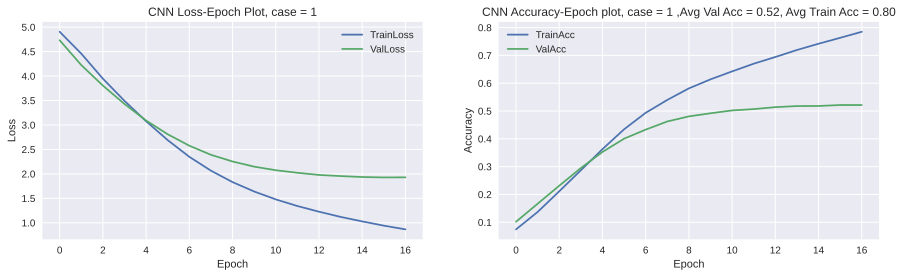

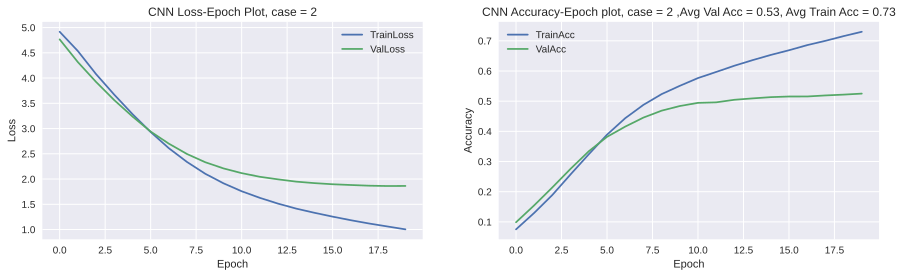

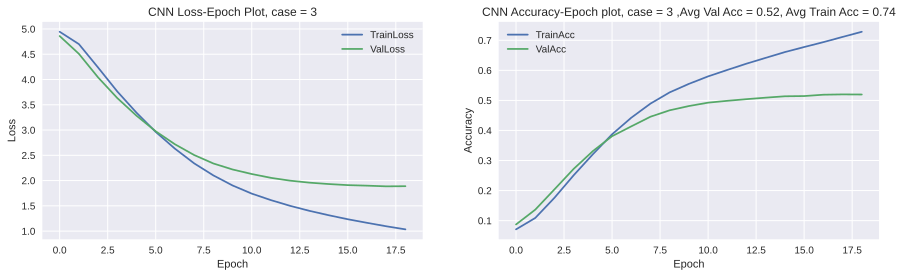

In [80]:
plotit()

**Inferences CBOW model**

The results clearly depict that for CBOW case, only a local information is enough to judge the word sense and obtain similar accuracy as compared to considering entire document. Notice the average accuracy obtained for all three cases is also presented here as table.

Case | Train Acc | Val Acc | Test Acc
---| --- | --- | --- 
1 | 0.80 | 0.52 | 0.51
2 | 0.73 | 0.53 | 0.52
3 | 0.74 | 0.52 | 0.51

Some top predictions made on individual sense by each case are shown here:

Case 1 | Case 2 | Case 3
--- | --- | ---
line.n = 0.83 | line.n = 0.85 | line.n = 0.82
bad.a = 0.67 | bad.a = 0.66 | bad.a = 0.66
keep.v = 0.64 | keep.v = 0.65 | keep.v = 0.63
see.v = 0.63 | see.v = 0.64 | order.n = 0.62

It is observed that all three cases are equally good, but the efficiency can be improved in case 2. Overall, the CBOW approach has worked well enough giving around 50-55% of correct word senses.             


# RNN

**Motivation**

At the beginning of CBOW modelling, a claim about position of words not being important. The results obtained from CBOW were much better than a random classifier but still far from state of the art WSD results. Now, considering an example - "*The cable line in the railway central line of xyz place is broken*". If we use the CBOW approach then the words "railway" will have a contribution to first "line" and the cable will have affect on second "line" which is undesirable. Now, intuitively one can claim that the position of words may have significant affect on extracting the sense of the word. Hence, a RNN will be used to train and predict the sense of lemma in a given set of documents. Specifically, the RNN (LSTM and GRU) has the ability to mix the embedding step by step i.e. the embeddings for first word is mixed with second and the resulting embedding is mixed with third and so on. This is how languages are read in general i.e. from left to right. However, a true sense to complete sentences comes when it is read entirely and hence bidirectional comes into picture. The bidirectional runs on the idea of going through a document by reading it twice i.e. from left to right and also from right to left. Hence, either of LSTM and GRU can be used to perform the task. It's really hard to say beforehand which one is ideal, however GRU's are faster as compared to LSTM due to lesser number of tensor operations involving. 

Therefore, a simple RNN, LSTM and GRU all three are ran independently with same hyperparameters. The method with highest validation accuracy will then be studied based for tuning of word embedding dimensionality.

# Training RNN models

Class that provides the embedded input tensor i.e. final states of input and output layer.

In [11]:
class RNNRepresentation(nn.Module):

    def __init__(self, voc_size, emb_dim, rnn_size, icase):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim)
        self.icase = icase

        # The RNN module: either a basic RNN, LSTM, or a GRU.
        if icase == 1:
          self.rnn = nn.RNN(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 2:
          self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)
        elif icase == 3:
          self.rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_size, bidirectional=True, num_layers=1, batch_first=True)

    def forward(self, X):
        # X is a document tensor with shape (n_docs, n_words)

        embedded = self.embedding(X)

        # Shape of embedded: (n_docs, n_words, emb_dim)

        # The RNNs return two tensors: one representing the outputs at all positions
        # of the final layer, and another representing the final states of each layer.
        # In this example, we'll use just the final states.
        # NB: for a bidirectional RNN, the final state corresponds to the *last* token
        # in the forward direction and the *first* token in the backward direction.
        if self.icase == 1 or self.icase == 3:
          rnn_out, final_state = self.rnn(embedded)
        elif self.icase == 2:
          # use the following instead if you're using an LSTM:
          rnn_out, (final_state, _) = self.rnn(embedded)

        # For a GRU or simple RNN, final_state is a single tensor
        # of the shape (n_layers, n_docs, 2*rnn_size)

        top_forward = final_state[-2]
        top_backward = final_state[-1]
        top_both = torch.cat([top_forward, top_backward], dim=1)

        return top_both

Class to define the hyperparameters for RNN model and performs the operations done by main i.e. calling the right functions from Text Classifier class to perform the training.

In [31]:
class TextClassifierParameters():
    """Container class to store the hyperparameters that control the training process."""

    # Computation device: 'cuda' or 'cpu'
    device = 'cuda'

    # Maximal vocabulary size: by increasing, the system will probably be slower but more accurate.
    max_voc_size = 1000

    # Number of training epochs.
    n_epochs = 20

    # Size of batches: how many documents to process in parallel.
    batch_size = 64

    # Learning rate in the Adam optimizer.
    eta = 2e-3

    # Weight decay (L2 regularization) in the Adam optimizer.
    decay = 1e-5

    # Dropout probability.
    dropout = 0.25

    # Word embedding dimensionality.
    emb_dim = 64

    # RNN size
    rnn_size = 128  # 128


def main_rnn(icase, jcase):

    # Read the data.
    X, Y, posVector = readData(filePath)

    print(f'Loaded {len(Y)} documents.')

    # Initialize the text classifier
    params = TextClassifierParameters()
    clf = TextClassifier(params)
    if jcase == 1:
      clf.params.emb_dim = 32
    elif jcase == 2:
      clf.params.emb_dim = 64
    elif jcase == 3:
      clf.params.emb_dim = 128

    # Preprocess the data.
    clf.preprocess(X, Y, ngrams = None, flagNoStop = None)

    # Create a classification model: a bag-of-words representation with a linear classifier on top,
    # and dropout to reduce overfitting.

    clf.set_model(nn.Sequential(
        RNNRepresentation(voc_size=clf.voc_size, emb_dim=params.emb_dim,
                          rnn_size=params.rnn_size, icase = icase),
        nn.Dropout(params.dropout),
        nn.Linear(in_features=2 * params.rnn_size, out_features=clf.n_classes)
    ))

    # Train the classifier.
    clf.train()

    return clf


In [32]:
maxIter = 5
finalAccRNNVal = list()
finalAccRNNTrain = list()
rnn_classifier = list()
for icase in range(3):
  rnn_classifier.append(list())
  finalAccRNNVal.append(np.zeros(maxIter))
  finalAccRNNTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier[icase].append(main_rnn(icase + 1, 2))
    finalAccRNNVal[icase][iterations] = rnn_classifier[icase][iterations].history['val_acc'][len(rnn_classifier[icase][iterations].history['val_acc']) - 1]
    finalAccRNNTrain[icase][iterations] = rnn_classifier[icase][iterations].history['train_acc'][len(rnn_classifier[icase][iterations].history['train_acc']) - 1]

Loaded 76049 documents.
Epoch 5: train loss: 5.2267, train acc: 0.0517, val loss: 5.1144, val acc: 0.0596, time: 15.6251
Epoch 10: train loss: 5.1256, train acc: 0.0584, val loss: 5.0863, val acc: 0.0670, time: 15.6224
Loaded 76049 documents.
Epoch 5: train loss: 5.0740, train acc: 0.0673, val loss: 5.0133, val acc: 0.0624, time: 15.4036
Epoch 10: train loss: 5.0103, train acc: 0.0685, val loss: 4.9825, val acc: 0.0733, time: 15.7566
Loaded 76049 documents.
Epoch 5: train loss: 4.9452, train acc: 0.0711, val loss: 4.9392, val acc: 0.0704, time: 15.6443
Loaded 76049 documents.
Epoch 5: train loss: 4.9585, train acc: 0.0719, val loss: 5.0134, val acc: 0.0728, time: 14.9281
Loaded 76049 documents.
Epoch 5: train loss: 4.9451, train acc: 0.0731, val loss: 4.9512, val acc: 0.0767, time: 14.9176
Epoch 10: train loss: 4.9308, train acc: 0.0721, val loss: 4.9401, val acc: 0.0748, time: 15.1090
Epoch 15: train loss: 5.0083, train acc: 0.0669, val loss: 4.9953, val acc: 0.0736, time: 15.1102
Loa

In [33]:
# Plot losses and accuracies for the training and validation sets.
def plotit_RNN():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(3):
    plt.figure(figsize=(15, 4))
    plt.subplot(1,2,1)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("RNN Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rnn_classifier[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(rnn_classifier[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"RNN Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccRNNVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccRNNTrain[icase]):.2f}")
    plt.legend()

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccRNNVal[icase])}, Avg Train Accuracy = {np.mean(finalAccRNNTrain[icase])}")

# Preliminary Result

From the below plots and table, it is clear that the performance by LSTM and GRU aren't significantly different. Since GRU are faster, the effect of hyperparameter embedding dimension will be done on GRU model. The training plot are skipped as this is only a preliminary result. 

Model | RNN | LSTM | GRU
--- | --- | --- | ---
Accuracy | 0.07 | 0.57 | 0.58

In [ ]:
plotit_RNN()

# Training with respect to hyperparameter tuning

In [35]:
maxIter = 5
finalAccGRUVal = list()
finalAccGRUTrain = list()
rnn_classifier_GRU = list()
for jcase in range(3):
  rnn_classifier_GRU.append(list())
  finalAccGRUVal.append(np.zeros(maxIter))
  finalAccGRUTrain.append(np.zeros(maxIter))
  for iterations in range(maxIter):
    rnn_classifier_GRU[jcase].append(main_rnn(3, jcase + 1))
    finalAccGRUVal[jcase][iterations] = rnn_classifier_GRU[jcase][iterations].history['val_acc'][len(rnn_classifier_GRU[jcase][iterations].history['val_acc']) - 1]
    finalAccGRUTrain[jcase][iterations] = rnn_classifier_GRU[jcase][iterations].history['train_acc'][len(rnn_classifier_GRU[jcase][iterations].history['train_acc']) - 1]

Loaded 76049 documents.
Epoch 5: train loss: 1.2675, train acc: 0.6243, val loss: 1.5058, val acc: 0.5768, time: 16.4213
Loaded 76049 documents.
Epoch 5: train loss: 1.2638, train acc: 0.6277, val loss: 1.4993, val acc: 0.5847, time: 16.3383
Loaded 76049 documents.
Epoch 5: train loss: 1.2893, train acc: 0.6197, val loss: 1.4962, val acc: 0.5805, time: 16.3397
Loaded 76049 documents.
Epoch 5: train loss: 1.2858, train acc: 0.6232, val loss: 1.5003, val acc: 0.5757, time: 16.2862
Loaded 76049 documents.
Epoch 5: train loss: 1.3428, train acc: 0.6021, val loss: 1.5331, val acc: 0.5659, time: 16.7177
Loaded 76049 documents.
Epoch 5: train loss: 1.5143, train acc: 0.5583, val loss: 1.6201, val acc: 0.5440, time: 16.3488
Epoch 10: train loss: 1.1004, train acc: 0.6687, val loss: 1.6164, val acc: 0.5738, time: 16.3248
Loaded 76049 documents.
Epoch 5: train loss: 1.4597, train acc: 0.5710, val loss: 1.5783, val acc: 0.5470, time: 16.3112
Epoch 10: train loss: 1.0141, train acc: 0.6918, val lo

In [36]:
# Plot losses and accuracies for the training and validation sets.
def plotit_GRU():
  iterationNumber = np.asscalar(np.random.randint(0, maxIter, 1))
  for icase in range(3):
    plt.figure(figsize=(15, 4))
    plt.subplot(1,2,1)
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['train_loss'], label = "TrainLoss")
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GRU Loss-Epoch Plot, case = " + str(icase + 1))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['train_acc'], label = "TrainAcc")
    plt.plot(rnn_classifier_GRU[icase][iterationNumber].history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"GRU Accuracy-Epoch plot, case = {icase + 1} ,Avg Val Acc = {np.mean(finalAccGRUVal[icase]):.2f}, Avg Train Acc = {np.mean(finalAccGRUTrain[icase]):.2f}")
    plt.legend()

    print(f"Average accuracy over multiple iterations, case = {icase + 1}, Avg Val Accuracy = {np.mean(finalAccGRUVal[icase])}, Avg Train Accuracy = {np.mean(finalAccGRUTrain[icase])}")

Performance on Test Dataset

In [ ]:
randomModel = np.asscalar(np.random.randint(0, maxIter, 1))
XTest, Ytest, posTest = readData(filePathTest)
for icase in range(3):
  resultList = rnn_classifier_GRU[icase][randomModel].predict(XTest)
  fileNameRes = "GRU_case_" + str(icase+1) + ".txt"
  fileName = filePathResult + fileNameRes
  writeData(fileName, resultList)
!python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt /content/drive/My\ Drive/MLNLP/Assignment3/GRU_case_1.txt
print("\n")
!python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt /content/drive/My\ Drive/MLNLP/Assignment3/GRU_case_2.txt
print("\n")
!python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt /content/drive/My\ Drive/MLNLP/Assignment3/GRU_case_3.txt

# Results and Inference from GRU models

The effect of embedding dimension is studied by only considering them fixed discrete values, specifically, embedding dimension is iterated over the set $\{32, 64, 128\}$. 5 iterations were performed for each of these cases. A randomly picked iteration is plotted. For each embedding dimension, training curve and accuracy plot is shown resulting in 6 plots. The average training and validation accuracies are mentioned on plot title(Right figures).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until


Average accuracy over multiple iterations, case = 1, Avg Val Accuracy = 0.5824852071005917, Avg Train Accuracy = 0.712648136885879
Average accuracy over multiple iterations, case = 2, Avg Val Accuracy = 0.5739250493096646, Avg Train Accuracy = 0.6868686204572725
Average accuracy over multiple iterations, case = 3, Avg Val Accuracy = 0.5973307034845495, Avg Train Accuracy = 0.7361593714558097


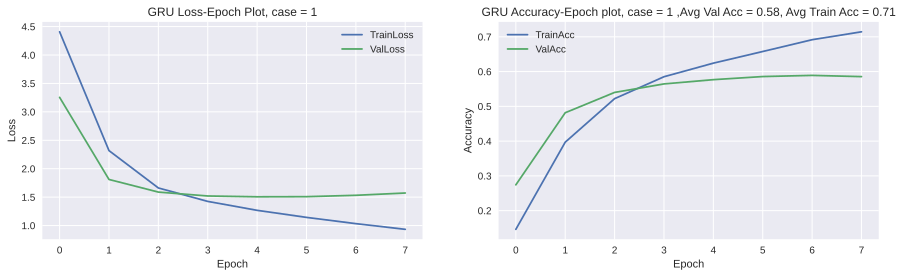

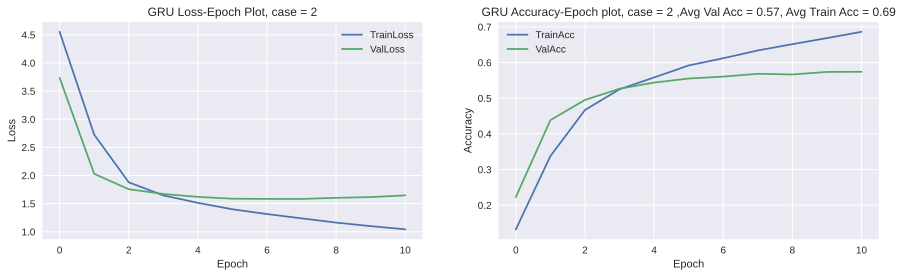

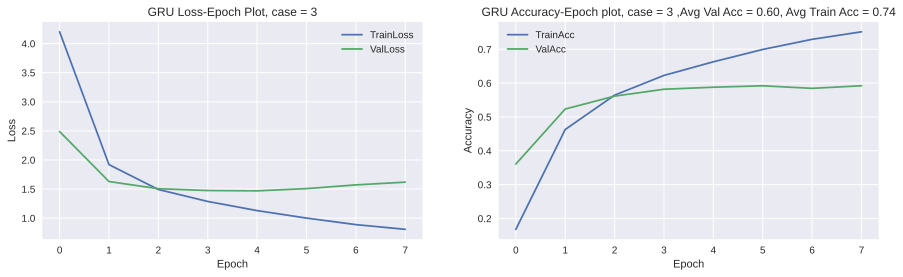

In [38]:
plotit_GRU()

**Inferences GRU model**

The results depict that the for case with enbedding dimension $= 128$, the validation and test accuracies were slightly better than other two cases. Hence, the hyperparameter needs additional tuning to fix embedding dimension for this scenario. 

Case | Train Acc | Val Acc | Test Acc
---| --- | --- | --- 
32 | 0.78 | 0.58 | 0.59
64 | 0.69 | 0.57 | 0.58
128 | 0.74 | 0.60 | 0.60

Some top predictions made on individual sense by each case are shown here:

Case 32 | Case 64 | Case 128
--- | --- | ---
line.n = 0.88 | line.n = 0.88 | line.n = 0.89
keep.v = 0.73 | keep.v = 0.71 | see.v = 0.71
see.v = 0.73 | see.v = 0.70 | keep.v = 0.70
professional.a = 0.67 | professional.a = 0.67 | active.a = 0.69

It is also observed that the lemma's that gave poor performances e.g. "build", "lead" etc have wide range of word sense but smaller training data. Hence, the question of how large training is required stil holds. Lastly, it can be observed that as expected, the overall test accuracy has improved a lot in case of GRU as compared to any of the CBOW model. 

# Additional Consideration

The performances in RNN clearly motivated to have a large training dataset. One way to overcome this is to use pretrained word embeddings like BERT. The next document contains the BERT model. Final conclusions are also drafted in that file. File name - "WSD_BERT.ipynb".